In [2]:
import os
from dotenv import load_dotenv
from IPython.display import display, Image

from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_core.tools.retriever import create_retriever_tool
from langgraph.checkpoint.memory import InMemorySaver

from typing import List
import logging
from langchain_community.tools import BraveSearch
from langchain_tavily import TavilyExtract
import json

# For QA-Retriever
from langchain_core.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

# Custom Import
from optcg.vectorstore_logic import check_for_updates_to_rules, create_or_load_vectorstore_optcg_rulebooks
from optcg.tools import web_search_tool, youtube_search_tool, create_rulebook_retriever_tool, card_search_tool, get_board_tool
from optcg.agents.react import BaseAgent, RulebookAgent
from optcg.routes import agent_routes, card_routes, board_routes


from langsmith import traceable
from langsmith.wrappers import wrap_openai
from openai import OpenAI
#openai_client = wrap_openai(OpenAI())

_ = load_dotenv() # Loads the .env file - e.g. the OPENAI_API_KEY

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


Loading existing vector store...
Loading existing vector store...


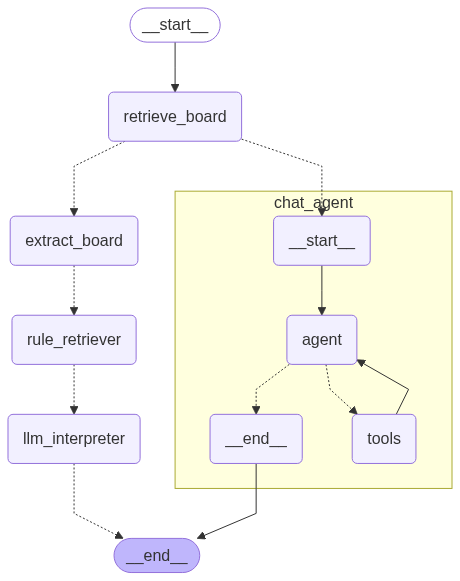

In [1]:
from optcg.agents.board_assistant import agent as board_agent
from IPython.display import display, Image

Image(board_agent.get_graph(xray=1).draw_mermaid_png())

In [5]:
res = board_agent.invoke({
    "messages": [],
    "user_message": "Can you help me understand how to play the game?"})

Getting board state via HTTP...


ERROR:root:Exception in get_board_tool: 404 Client Error: Not Found for url: http://localhost:8000/board/
Traceback (most recent call last):
  File "C:\Users\tyson\repos\sail-2025-optcg\backend\src\optcg\tools.py", line 75, in get_board_tool_http
    response.raise_for_status()
    ~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\tyson\repos\sail-2025-optcg\backend\.venv\Lib\site-packages\requests\models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: http://localhost:8000/board/


Board State Retrieved: {'error': 'No board state found. Please tell user to update the board state first.'}


ValueError: Must specify non-null arguments for both 'left' and 'right'. Only received: 'right'.

In [1]:
from optcg.agents.board_assistant import extract_board_state
import json

with open("test_state_hand.json", "r") as f:
    game_state = json.load(f)

res = extract_board_state({
    "user_message": "What should I do this turn?",
    "thread_id": "thread_123",
    "board": game_state})

Loading existing vector store...


In [2]:
from optcg.agents.board_assistant import rulebook_retriever, retriever

res1 = rulebook_retriever({
    "user_message": "What should I do this turn?",
    "extraction": res,
    "thread_id": "thread_123",
    "board": game_state})
res1


"7. Card Attacks and Battles  \n7-1. During the Main Phase, the turn player can rest an active Leader card in their Leader \narea, or an active Character card in their Character area, to attack an opponent’s Leader \ncard in their Leader area, or rested Character card in their Character area. When an \nattack is made, the game proceeds to Battle (see 6-5-6.) and is processed in order from \nthe Attack Step (see 7-1-1.) to the Damage Step (see 7-1-4.). \n7-1-1. Attack Step \n7-1-1-1. Attacks are carried out by the Leader card, or a Character card in the \nCharacter area. First,  the turn player  declares their attack by resting their  \nactive Leader card or 1 active Character card. \n7-1-1-2. The turn player then selects the target of their attack. The target can be either \nthe opponent’s Leader card or 1 of their rested Character cards in their \nCharacter area. \n7-1-1-3. Effects that read [When Attacking] , “when you attack ”, or [On Your \nOpponent's Attack] activate. \n7-1-1-4. I

In [4]:
from optcg.agents.board_assistant import llm_interpretation

res2 = llm_interpretation({
    "user_message": "What should I do this turn?",
    "retrieval": res1,
    "extraction": res,
    "thread_id": "thread_123",
    "board": game_state})
res2

Command(update={'messages': [{'role': 'user', 'content': 'What should I do this turn?'}, {'role': 'assistant', 'content': 'Given your current board state and hand, here’s a strategic breakdown and suggested play for your turn:\n\n## Your Board\n- Leader: Roronoa Zoro (OP01-001) — [DON!! x1] [Your Turn] All of your Characters gain +1000 power.\n- Characters: Roronoa Zoro (OP01-025, 5000, Rush), Nico Robin (OP01-017, 4000, [DON!! x1] [When Attacking] K.O. up to 1 of your opponent\'s Characters with 3000 power or less), Marco (OP01-023, 5000)\n- DON!!: 7 available, all active\n- Life: 4\n- Hand: 3x Otama (OP01-006, 2000 counter), 2x Marco (OP01-023, 1000 counter)\n\n## Opponent’s Board\n- Leader: Eustass "Captain" Kid (ST02-001, 5000, [Activate: Main] [Once Per Turn] 3 DON!!, trash 1 card: Set this Leader as active)\n- Characters: 3x Nami (OP02-036, 5000 each)\n- DON!!: 8 available, all active\n- Life: 3\n- Hand: 5 cards\n\n## Key Considerations\n- All of your opponent’s Namis are 5000 po

In [4]:
res2.update["messages"]

[HumanMessage(content='What should I do this turn?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Given your current board state and hand, here’s a strategic breakdown and suggested play for your turn:\n\n### Your Board\n- Leader: Roronoa Zoro (OP01-001) — [DON!! x1] [Your Turn] All of your Characters gain +1000 power.\n- Characters: \n  - Roronoa Zoro (OP01-025) [Rush], 5000 power\n  - Nico Robin (OP01-017), 4000 power, [DON!! x1] [When Attacking] K.O. up to 1 of your opponent\'s Characters with 3000 power or less.\n  - Marco (OP01-023), 5000 power\n- DON!!: 7 available\n- Hand: 3x Otama (each with 2000 counter), 2x Marco\n\n### Opponent’s Board\n- Leader: Eustass "Captain" Kid (ST02-001)\n- Characters: 3x Nami (OP02-036), each 5000 power\n- DON!!: 8 available\n- Life: 3\n\n---\n\n## Strategic Considerations\n\n- Your opponent has three 5000 power Nami characters, which are not easily removed by Nico Robin’s effect alone.\n- You have a strong board presence and a h

In [3]:
from optcg.agents.board_assistant import extract_board_state
import json

with open("test_state_hand.json", "r") as f:
    game_state = json.load(f)

res = extract_board_state({
    "message": "How should I attack this turn?",
    "thread_id": "thread_123",
    "board": game_state})

Extraction Result: queries=['What are the rules for attacking with a character or leader?', 'How does the DON!! system work for powering up attacks?', 'How do counter abilities work during the attack phase?', 'How does the [Rush] ability allow a character to attack the turn it is played?', "How does the [When Attacking] ability on a character work, specifically for K.O.-ing opponent's characters?", "How does the [DON!! x1] ability on the leader affect all characters' power?", "What are the rules for attacking opponent's characters versus attacking the leader?", "How does the opponent's leader ability to re-stand work during your attack phase?"]


In [ ]:
res.queries

In [1]:
from optcg.agents.board_assistant import extract_board_state
import json

with open("test_state_hand.json", "r") as f:
    game_state = json.load(f)

res = extract_board_state({
    "message": "How should I play my hand this turn?",
    "thread_id": "thread_123",
    "board": game_state})

Loading existing vector store...
Loading existing vector store...
Loading existing vector store...
Extraction Result: queries=['What are the rules for playing character cards from hand?', 'How does the DON!! system work for paying costs and powering up attacks?', 'How do [On Play] abilities resolve when playing a character?', 'What are the rules for attacking with a character or leader?', 'How do counter abilities work during the attack phase?', 'How do abilities that trigger using DON!! work?', 'How does the [Rush] ability work for attacking the turn a character is played?', 'How do [When Attacking] abilities resolve?']
Extraction Result: queries=['What are the rules for playing character cards from hand?', 'How does the DON!! system work for paying costs and powering up attacks?', 'How do [On Play] abilities resolve when playing a character?', 'What are the rules for attacking with a character or leader?', 'How do counter abilities work during the attack phase?', 'How do abilities th

In [5]:
res.queries

['What are the rules for attacking with a character or leader?',
 'How does the DON!! system work for powering up attacks?',
 'How do counter abilities work during the attack phase?',
 'How does the [Rush] ability allow a character to attack the turn it is played?',
 "How does the [When Attacking] ability on a character work, specifically for K.O.-ing opponent's characters?",
 "How does the [DON!! x1] ability on the leader affect all characters' power?",
 "What are the rules for attacking opponent's characters versus attacking the leader?",
 "How does the opponent's leader ability to re-stand work during your attack phase?"]

In [4]:
import os
import json
import requests
from dotenv import load_dotenv

# filepath: c:\Users\Tyson Franke\repos\sail-2025-optcg\backend\post_board_state.py

# Load env vars (OPENAI_API_KEY, API_BASE_URL, etc.)
load_dotenv()

api_base = os.getenv("API_BASE_URL", "http://localhost:8000")
url = f"{api_base}/board/"

# Load your test state from disk
with open("test_state.json", "r") as f:
    payload = json.load(f)

# Send POST request
resp = requests.post(url, json=payload)
resp.raise_for_status()

print("Status:", resp.status_code)
print("Response:", resp.json())

res = requests.get(url)
print("Status:", res.status_code)
print("Response:", res.json())

Status: 200
Response: {'status': 'Board state saved successfully'}
Status: 200
Response: {'UserState': {'life': 4, 'don': 7, 'leader': {'id': 'OP01-001', 'code': 'OP01-001', 'rarity': 'L', 'type': 'LEADER', 'name': 'Roronoa Zoro', 'images': {'small': 'https://en.onepiece-cardgame.com/images/cardlist/card/OP01-001.png', 'large': 'https://en.onepiece-cardgame.com/images/cardlist/card/OP01-001.png'}, 'cost': 5, 'attribute': {'name': 'Slash', 'image': 'https://en.onepiece-cardgame.com/images/cardlist/attribute/ico_type02.png'}, 'power': 5000, 'counter': '-', 'color': 'Red', 'family': 'Supernovas/Straw Hat Crew', 'ability': '[DON!! x1] [Your Turn] All of your Characters gain +1000 power.', 'trigger': '', 'set': {'name': '-ROMANCE DAWN- [OP01]'}, 'notes': []}, 'event': None, 'stage': None, 'character': [{'id': 'OP01-025', 'code': 'OP01-025', 'rarity': 'SR', 'type': 'CHARACTER', 'name': 'Roronoa Zoro', 'images': {'small': 'https://en.onepiece-cardgame.com/images/cardlist/card/OP01-025.png', '

In [11]:
from optcg import state
print(state.current_board_state)

None


In [9]:
from optcg.tools import get_board_tool
get_board_tool.invoke("")

{'error': 'No board state found. Please tell user to update the board state first.'}

In [5]:
from optcg.agents.board_assistant import boardstate_retrieval
boardstate_retrieval({"board": {"turn": 1, "phase": "main", "hand": [], "deck": [], "graveyard": [], "exile": [], "battlefield": []}})

Board State Retrieved: {'error': 'No board state found. Please tell user to update the board state first.'}


Command(update={'board': {'error': 'No board state found. Please tell user to update the board state first.'}}, goto='chat_agent')

In [5]:
agent = RulebookAgent()
agent.chat("what is the current board state?", verbose=True)

2025-07-29 13:56:11,903 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


Loading existing vector store...


2025-07-29 13:56:13,190 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-29 13:56:14,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='what is the current board state?', additional_kwargs={}, response_metadata={}, id='a7bf0bb1-1caf-4bef-b2a9-99918b24a150'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KZ4nYilyVa91cMuK9pnz3577', 'function': {'arguments': '{}', 'name': 'get_board_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 267, 'total_tokens': 278, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b3f1157249', 'id': 'chatcmpl-ByjmemAdJ92zJirybRq5ndl8RdsSJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='RulebookAgent', id='run--50d3be73-fec6-4243-9692-0e1099fef6f7-0', tool_calls=[{'name': 'get_board_tool', 'args': {}, 'id': 'call_

In [4]:
from optcg import state
print(state.current_board_state)

None


In [2]:
get_board_tool.invoke("what is on the board?")

{'error': 'No board state found. Please tell user to update the board state first.'}

In [18]:
import requests
api_base_url = os.getenv("API_BASE_URL", "http://localhost:8000")
print(f"Using API base URL: {api_base_url}")
print("{}/board/".format(api_base_url))
response = requests.get(
            f"{api_base_url}/board/"
        )
response.json()

Using API base URL: http://localhost:8000
http://localhost:8000/board/


{'UserState': {'life': 0,
  'don': 0,
  'leader': {'id': 'ST13-015_p1',
   'code': 'ST13-015',
   'rarity': 'SR',
   'type': 'CHARACTER',
   'name': 'Monkey.D.Luffy',
   'images': {'small': 'https://en.onepiece-cardgame.com/images/cardlist/card/ST13-015_p1.png?241220',
    'large': 'https://en.onepiece-cardgame.com/images/cardlist/card/ST13-015_p1.png?241220'},
   'cost': 5,
   'attribute': {'name': 'Strike',
    'image': 'https://en.onepiece-cardgame.com/images/cardlist/attribute/ico_type01.png'},
   'power': 6000,
   'counter': '1000',
   'color': 'Yellow',
   'family': 'Supernovas/Straw Hat Crew',
   'ability': '[Activate: Main] [Once Per Turn] This Character gains +2000 power until the start of your next turn. Then, if you have 1 or more Life cards, draw 1 card and trash 1 card from the top of your Life cards.',
   'trigger': '',
   'set': {'name': '-The Three Brothers-[ST13]'},
   'notes': []},
  'event': None,
  'stage': None,
  'character': []},
 'OpponentState': {'life': 0,
  '

In [ ]:
with open("test_state_hand.json", "r") as f:
    game_state = json.load(f)
query = "What is the current game state? What are the next possible moves for each player?"
query = "What characters are on the board, and what are their abilities? What is the current life total for each player?"
query = "What should should I be wary of in the current game state?"

query_prompt_template = PromptTemplate.from_template("""
Here is the Current Game State:
{game_state} \n
You are an expert in the game of One Piece TCG. Based on the current game state, please address the following query. Try to keep the response concise and focused on the most relevant information for the query.:
{query}
""")
query_prompt = query_prompt_template.invoke({
    "game_state": game_state,
    "query": query
}).text

agent.chat(query_prompt, thread_id="test1234")

2025-07-24 16:35:11,572 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Here are the key things you should be wary of in the current game state:\n\n1. Opponent’s Leader Ability (Eustass "Captain" Kid):  \nKid can restand himself once per turn by resting 3 DON!! and trashing a card. This means your opponent can attack twice with their Leader, potentially putting more pressure on your Life or Characters.\n\n2. Opponent’s Board (Triple Nami):  \nYour opponent has three Nami (OP02-036), each with 5000 power. While their ability is mainly for searching {FILM} cards, they can still attack and pressure your Life or Characters. Be cautious if your Life is low or if you have vulnerable Characters.\n\n3. Opponent’s DON!! Advantage:  \nYour opponent has 8 DON!! available, giving them flexibility to power up attacks, use abilities, or play Events. Watch for potential power boosts or defensive Events during your attacks.\n\n4. Your Board State:  \nYou have strong attackers (Zoro Leader, Zoro Character with Rush, Nico Robin, Marco). However, be mindful of overextending

: 

'Here are the main things you should be wary of in the current game state:\n\n1. **Eustass "Captain" Kid Leader Ability**: Your opponent\'s leader can, once per turn, rest 3 DON!! and trash a card from their hand to set their Leader as active. This means Kid can attack twice in a turn, or attack and then be ready to block or threaten another attack. Be careful not to leave yourself open to multiple attacks, especially if you are low on life.\n\n2. **Multiple Nami (OP02-036) Characters**: Your opponent has three Nami (OP02-036) on the field. Each Nami can, when attacking (by resting 1 DON!!), look at the top 3 cards of their deck and add a {FILM} card (other than Nami) to their hand. This can quickly refill their hand and give them access to powerful {FILM} cards, including events or characters that could swing the game.\n\n3. **Potential for Multiple Attacks**: With three Nami and Kid, your opponent can attack multiple times in a turn. Even though Nami\'s power is only 5000, if you are not careful, you could lose several life in one turn, especially if you cannot block or counter enough attacks.\n\n4. **Trigger Effects**: When you take damage, remember that your opponent may be trying to push you into activating a [Trigger] effect from your life cards. Be aware of what triggers you have in your deck and how they might affect the game state.\n\n5. **Hand Size and Resources**: With Nami\'s effect, your opponent can increase their hand size and find key cards. If you let them keep all three Nami on the field, they will have a significant resource advantage over time.\n\n**Strategic Advice:**\n- Try to remove at least one or more Nami if possible, to slow down your opponent\'s card advantage.\n- Be cautious about overextending, as Kid\'s double attack can quickly deplete your life.\n- Plan your counters and blockers carefully, especially if you expect a big turn from your opponent.\n- Watch your own hand size and resources, as you may need to defend against multiple attacks in a single turn.\n\nIf you have any removal or ways to disrupt your opponent\'s board, now is a good time to use them!'


In [4]:
agent = RulebookAgent()
agent.chat(query_prompt, thread_id="test")
agent.chat("How do you recommend that I attack the opponet?", verbose=True, thread_id="test")

Loading existing vector store...


2025-07-24 16:13:46,721 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-24 16:13:47,972 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-24 16:13:49,098 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-24 16:14:03,002 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='\nHere is the Current Game State:\n{\'UserState\': {\'life\': 4, \'don\': 7, \'leader\': {\'id\': \'OP01-001\', \'code\': \'OP01-001\', \'rarity\': \'L\', \'type\': \'LEADER\', \'name\': \'Roronoa Zoro\', \'images\': {\'small\': \'https://en.onepiece-cardgame.com/images/cardlist/card/OP01-001.png\', \'large\': \'https://en.onepiece-cardgame.com/images/cardlist/card/OP01-001.png\'}, \'cost\': 5, \'attribute\': {\'name\': \'Slash\', \'image\': \'https://en.onepiece-cardgame.com/images/cardlist/attribute/ico_type02.png\'}, \'power\': 5000, \'counter\': \'-\', \'color\': \'Red\', \'family\': \'Supernovas/Straw Hat Crew\', \'ability\': \'[DON!! x1] [Your Turn] All of your Characters gain +1000 power.\', \'trigger\': \'\', \'set\': {\'name\': \'-ROMANCE DAWN- [OP01]\'}, \'notes\': []}, \'event\': None, \'stage\': None, \'character\': [{\'id\': \'OP01-025\', \'code\': \'OP01-025\', \'rarity\': \'SR\', \'type\': \'CHARACTER\', \'name\': \'Roronoa Zoro\', \'i

In [4]:
class CardDBToolAgent(BaseAgent):
    # If model and temperature are not specified, defaults will be used, defined in BaseAgent.
    def __init__(self, model_name="gpt-4.1"):
        self.name = "CardDBToolAgent"
        super().__init__(model_name=model_name, temperature=0)
    
    def _create_prompt(self):
        """Create a system prompt for the agent. This should be tailored to the specific agent's purpose."""
        return "You are a helpful assistant that helps people answer information about the One Piece TCG. If you don't know the answer, just say you don't know. Do not try to make up an answer."

    def _setup_tools(self):
        """Setup tools for this agent. This can include any tools you want to use, or be an empty list if no tools are needed."""
        return [
            card_search_tool
        ]
agent = CardDBToolAgent(model_name="gpt-4.1")
agent.chat("What is a luffy card with power 2000?", verbose=True)

2025-07-08 10:48:14,168 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-08 10:48:23,571 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='What is a luffy card with power 2000?', additional_kwargs={}, response_metadata={}, id='f0634f71-2b2f-4773-9a26-2f5360ba79ef'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qql4dwe1156hSAxtHpxKVV0k', 'function': {'arguments': '{"input":{"query":"Luffy","power":2000}}', 'name': 'card_search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 227, 'total_tokens': 250, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-Br4qDTNS62PBFT25NEzWWTErLsRvw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='CardDBToolAgent', id='run--4c53ad13-a875-43d3-87f3-243e226e6315-0', tool_calls=[{'na